# Heat Pump 
(using the new components [comp.py] structure)
The (new) structure needs a (yaml or json)file or a dictionary with the configuration of the whole cycle or at least the component and the fluids.
An example is in the data folder. Most defaults are found in the CB_Default dictionary, e.g. the place of the data folder.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import carbatpy as cb

dir_name = cb.CB_DEFAULTS["General"]["CB_DATA"]+"\\io-cycle-data.yaml"

You are using this custom set ('CARBATPY_BASE_DIR') base directory for carbatpy: C:\Users\atakan\sciebo\Python\carbatpy\src\carbatpy


## Typical Procedure

#### Now we are ready for going through the calculations. It always consists of two steps (at least) 
* creating an instance of the component with all the things, which remain unchanged or are set to some default value
* doing the calculations, with actual input/output states and additional parameters needed.
The starting point of the working fluid state in the cycle is fixed, which also has to be the ending point here:

In the yaml file, you will find the state entering the compressor defined here:


    start:
      calc_type: null
      dt_min: 3.0
      dt_superheat: 5.0
      model: Start
      species:
        cold_storage:
          in: temp_high
          out: temp_high
          p_in: p_low
          p_out: p_low
        working_fluid:
          in: temp_start
          out: temp_start
          p_in: p_low
          p_out: p_low
and:

    working_fluid:
      fractions:
      - 0.771733787
      - 0.0222759488
      - 0.178685867
      - 0.027304397199999997
      optimize: None
      p_high: 1375487.28
      p_low: 112825.0708
      props: REFPROP
      setting: initial
      species: Propane * Butane * Pentane * Hexane
      temp_high: 3.94957070e+02
      temp_low: ambient
and:

    cold_storage:
      fixed: null
      fractions:
      - 1.0
      p_low: 200000.0
      props: REFPROP
      species: Methanol
      temp_high: ambient
      temp_low: 245.0

The ambient temperature is coming from the defaults.  Here the saturated vapor pressure (q=1) is calculated at $T_{ambient}-T_{superheat}-T_{min}$ and set as default, if the conditions are not fulfilled. 
## Calculations
We are going through a heat pump cycle with a two-storage heat sink (*hot storage*) starting at ambient temperature and a two-storage heat source (*cold_storage*), also starting at ambient temperature. The working fluid is an alkane mixture, as defined above. For the starting point no calculation is required.The mass flow rate is a dummy at the moment, it is needed for correct plotting on a $T- \dot H$ diagram, thus this will be recalculated again with the correct mass flow rate, it is for setting the correct value then.

In [2]:
start = cb.comp.Start("start", dir_name, m_dot=10e-3)

Let us continue with the compressor, here the power is prescribed and the final pressure. At the moment, only a very simple model is implemented: $\eta_s =const$. Thus from the output array only the pressure is used, the rest are dummies.

In [3]:
run_p_comp = {"power": 1500.}
compressor = cb.comp.FlowMachine("compressor", dir_name)
p_high = compressor.config['working_fluid']['p_high']
compressor.calculate(start.output["state_out"],
                     {'working_fluid': [600, p_high, 5e5]},
                     run_param=run_p_comp)

2024-08-15 11:07:38,463 - carbatpy.models.components.comp.compressor - INFO - Calculating compressor


Knowing the mass flow rate, we can set it for the starting point:

In [4]:
m_dot_w = compressor.output["m_dot"]
start = cb.comp.Start("start", dir_name, m_dot=m_dot_w)

Condenser, throttle and evaporator follow. The inleet states are taken from the ouputs of the components before. For the condenser and the evaporator the working fluid mass flow rates are fixed. Nothing is optimized so far!

In [5]:
run_p_cond = {"m_dot": {"working_fluid": m_dot_w}}

condenser = cb.comp.StaticHeatExchanger("condenser", dir_name)
condenser.calculate(run_param=run_p_cond)

The output state of the working fluid can be varied in order to minimize the meant temperature difference between heat source and heat sink:

In [6]:
condenser.hex_opti_work_out(run_p_par=run_p_cond)

condenser.output["state_out"]["working_fluid"]
throttle = cb.comp.Throttle("throttle", dir_name)
throttle.calculate(condenser.output["state_out"]["working_fluid"],
                   compressor.output["state_in"],
                   m_dot=m_dot_w)

evaporator = cb.comp.StaticHeatExchanger("evaporator", dir_name)
inp1, outp1 = evaporator.set_in_out(
    {'working_fluid': throttle.output['state_out']["working_fluid"]})
inp2, outp2 = evaporator.set_in_out(
    start.output['state_in'], False)
evaporator.calculate(inp1, outp2, run_param=run_p_cond)

2024-08-15 11:07:55,665 - carbatpy.models.components.comp.throttle - INFO - Calculating throttle


Optimization terminated successfully.
         Current function value: 15.060171
         Iterations: 30
         Function evaluations: 60


For the evaporator the ouput state of the working fluid should not be optimized without a new full cycle calculation, because the starting state would no longer be the final state, thus, we would not have a steady-state cycle. One could consider to vary the ouput temperature of the cold-storage fluid, but this not implemented yet, and when doing this by the user manually, it should be checked that the fluid is not freezing.

If you want to see the results check the output dictionary, but first check the warnings of each device e.g.:

In [12]:
for comp_act in condenser.config['process']["cycle"]:
    print(f'Component: {comp_act}, Warning: {locals()[comp_act].warning}')

print("\ncondenser-output:\n", condenser.output)

Component: start, Warning: namespace(value=0, message='All o.k.')
Component: compressor, Warning: namespace(value=0, message='All o.k.')
Component: condenser, Warning: namespace(value=0, message='All o.k.')
Component: throttle, Warning: namespace(value=0, message='All o.k.')
Component: evaporator, Warning: namespace(value=0, message='All o.k.')
Component: start, Warning: namespace(value=0, message='All o.k.')

condenser-output:
 {'m_dot': {'working_fluid': np.float64(0.008323401709372154), 'hot_storage': np.float64(0.014912595120661088)}, 'state_in': {'working_fluid': array([ 3.94957070e+02,  1.37548728e+06,  6.97312863e+05,  4.12463338e-02,
        2.46366821e+03, -9.99999000e+06,  6.40579056e+05]), 'hot_storage': array([ 2.88150000e+02,  1.99999999e+05,  6.31712968e+04,  1.00085204e-03,
        2.24433418e+02, -9.99999000e+06,  6.29711264e+04])}, 'state_out': {'working_fluid': array([ 2.91149004e+02,  1.37548732e+06,  1.58515587e+05,  1.83638602e-03,
        8.68267758e+02, -9.999990

From this, you can get e.g. the transfered heat (q_dot) or the mean temperature difference between both fluids (dt_mean), both mass flow rates and the really used in and output states. Or the COP:

In [8]:
print(f"COP: {np.abs(condenser.output["q_dot"]/run_p_comp["power"]):.4f}")

COP: 2.9898


##Plotting
Now we come to plotting. In order to have a meaningful legend and lines etc, there is plot_info defined. The plot method not only plots but also returns the minimum and maximum of $\dot H$, as well as the direction, is the enthalpy increasing or decreasing in the previous process. Accordingly we choose the starting point for the next one.

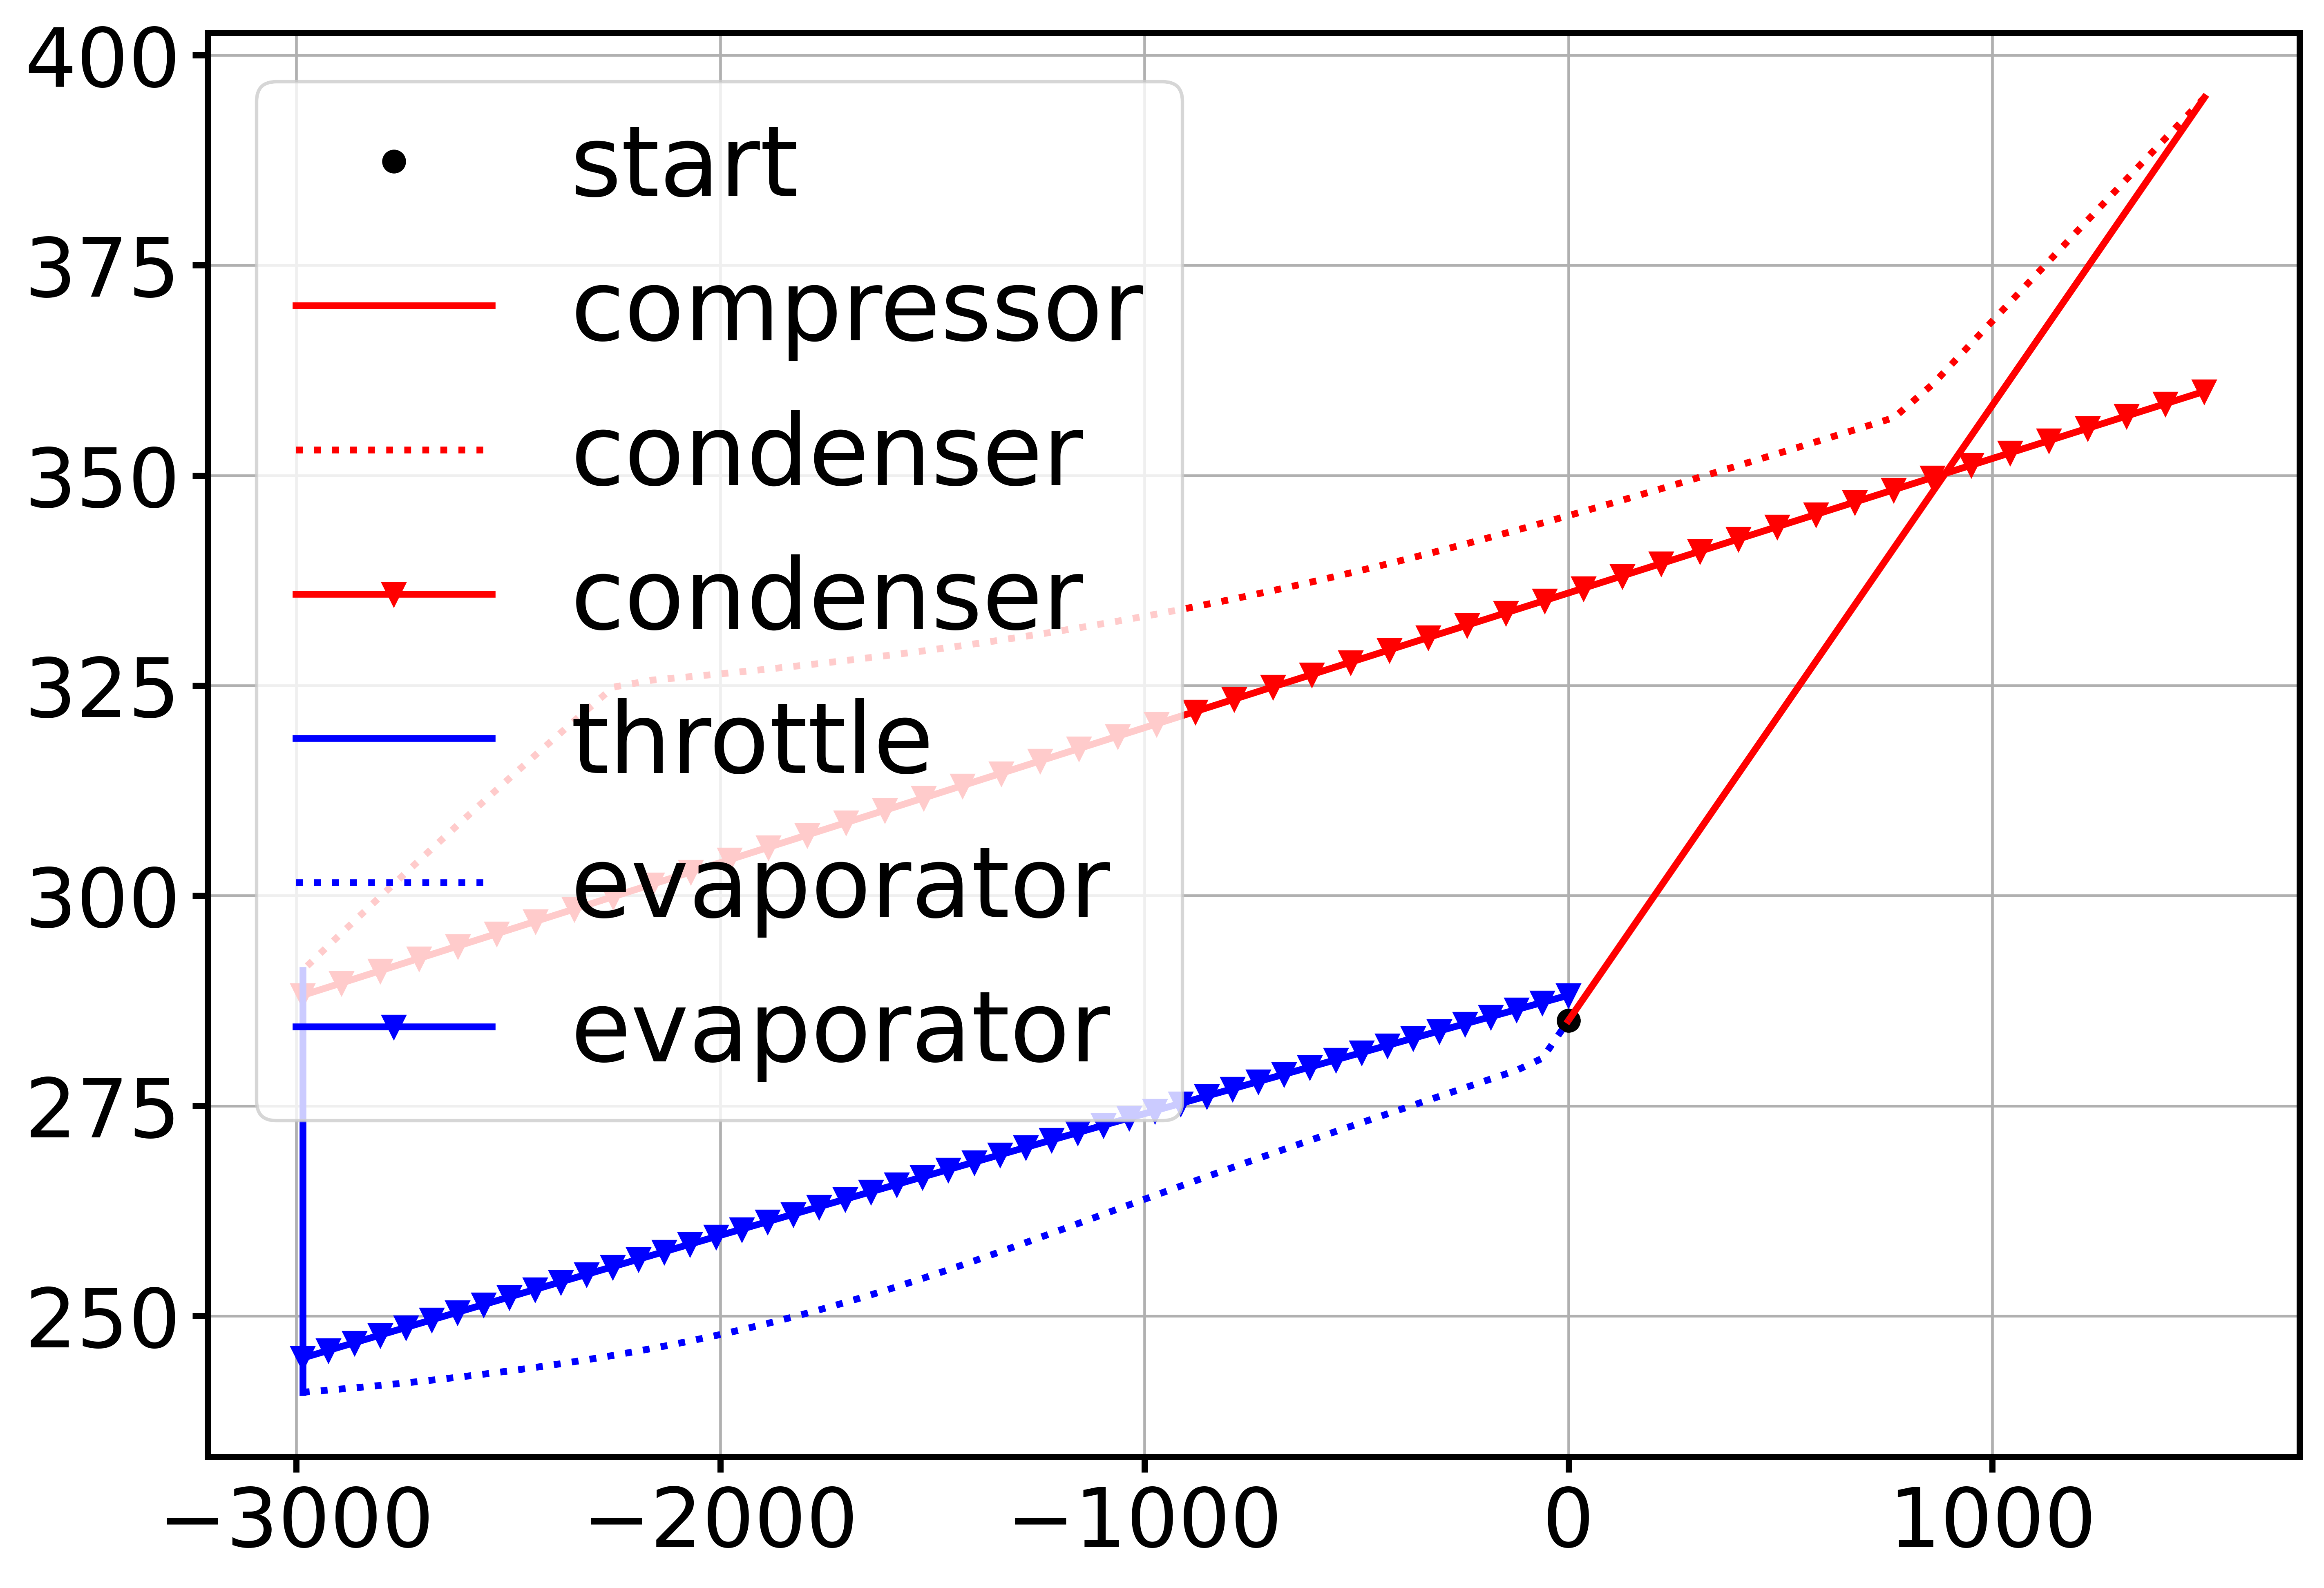

In [9]:
fig, ax = plt.subplots(1)
plot_info = cb.CB_DEFAULTS["Components"]["Plot"]
plot_info.update({"ax": ax, "fig": fig})

pl_inf = plot_info.copy()  # for the starting point (dot)
pl_inf.update({"label": ["start", ""],
               "col": ["ok", "bv"],
               "direction": 1, })

shift, direct = start.plot(pl_inf)

plot_info.update({"x-shift": shift,
                  "direction": direct,
                  "label": [compressor.name, ""],
                  "col": ["-r", "bv-"]})
shift, direct = compressor.plot(plot_info)

plot_info.update({"x-shift": shift,
                  "direction": direct,
                  "label": [condenser.name, ""],
                  "col": [":r", "rv-"]})
shift, direct = condenser.plot(plot_info)

plot_info.update({"x-shift": shift,
                  "direction": direct,
                  "label": [throttle.name, ""],
                  "col": ["-b", "bv-"]})
shift, direct = throttle.plot(plot_info)

plot_info.update({"x-shift": shift,
                  "direction": direct,
                  "label": [evaporator.name, ""],
                  "col": [":b", "bv-"]})
shift4 = evaporator.plot(plot_info)
